# Prevendo o score de um video-game na IGN

**Autor: Enricco Gemha**

## Problema de Regressão

Trataremos de um problema de regressão, um tipo de problema de aprendizado supervisionado.

A medida de performance que será usada para este problema é o RMSE (*Root Mean Square Error*). Vale lembrar que o RMSE é dado por:


$$RMSE(\mathbf{X}, \mathbf{y}, h) = 
\sqrt{\frac{1}{m} \sum_{i=1}^{m}\left(h(\mathbf{x}_i) - \mathbf{y}_i\right)^{2}}$$


*Obs: Escolhi este dataset para treinar para minha prova de Machine Learning na faculdade.*

## Importando as bibliotecas

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import os

FILEPATH = os.path.join('ign.csv')

Vamos fixar a semente do gerador de números aleatórios, para ter reproducibilidade neste notebook.

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Análise exploratória

### Carregando os dados

In [3]:
def load_ign_data(ign_file=FILEPATH):
    return pd.read_csv(ign_file)

ign = load_ign_data()
type(ign)

pandas.core.frame.DataFrame

### Entendendo os dados

Segundo a descrição da *database*, cada linha representa um título de video-game lançado.

In [4]:
# Dropa as colunas que não serão utilizadas
ign = ign.drop(['Unnamed: 0', 'url', 'title'], axis=1)

In [5]:
ign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18625 entries, 0 to 18624
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   score_phrase    18625 non-null  object 
 1   platform        18625 non-null  object 
 2   score           18625 non-null  float64
 3   genre           18589 non-null  object 
 4   editors_choice  18625 non-null  object 
 5   release_year    18625 non-null  int64  
 6   release_month   18625 non-null  int64  
 7   release_day     18625 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 1.1+ MB


In [6]:
ign

,score_phrase,platform,score,genre,editors_choice,release_year,release_month,release_day
0,Amazing,PlayStation Vita,9.0,Platformer,Y,2012,9,12
1,Amazing,PlayStation Vita,9.0,Platformer,Y,2012,9,12
2,Great,iPad,8.5,Puzzle,N,2012,9,12
3,Great,Xbox 360,8.5,Sports,N,2012,9,11
4,Great,PlayStation 3,8.5,Sports,N,2012,9,11
...,...,...,...,...,...,...,...,...
18620,Good,Wii U,7.6,RPG,N,2016,6,29
18621,Amazing,PlayStation 4,9.0,"Action, Adventure",Y,2016,6,29
18622,Mediocre,PlayStation 4,5.8,RPG,N,2016,6,28
18623,Masterpiece,Xbox One,10.0,Adventure,Y,2016,6,28


In [7]:
numerical_columns = list(ign.describe().columns)
ign.describe() # somente para dados númericos

,score,release_year,release_month,release_day
count,18625.000000,18625.000000,18625.00000,18625.000000
mean,6.950459,2006.515329,7.13847,15.603866
std,1.711736,4.587529,3.47671,8.690128
min,0.500000,1970.000000,1.00000,1.000000
25%,6.000000,2003.000000,4.00000,8.000000
50%,7.300000,2007.000000,8.00000,16.000000
75%,8.200000,2010.000000,10.00000,23.000000
max,10.000000,2016.000000,12.00000,31.000000


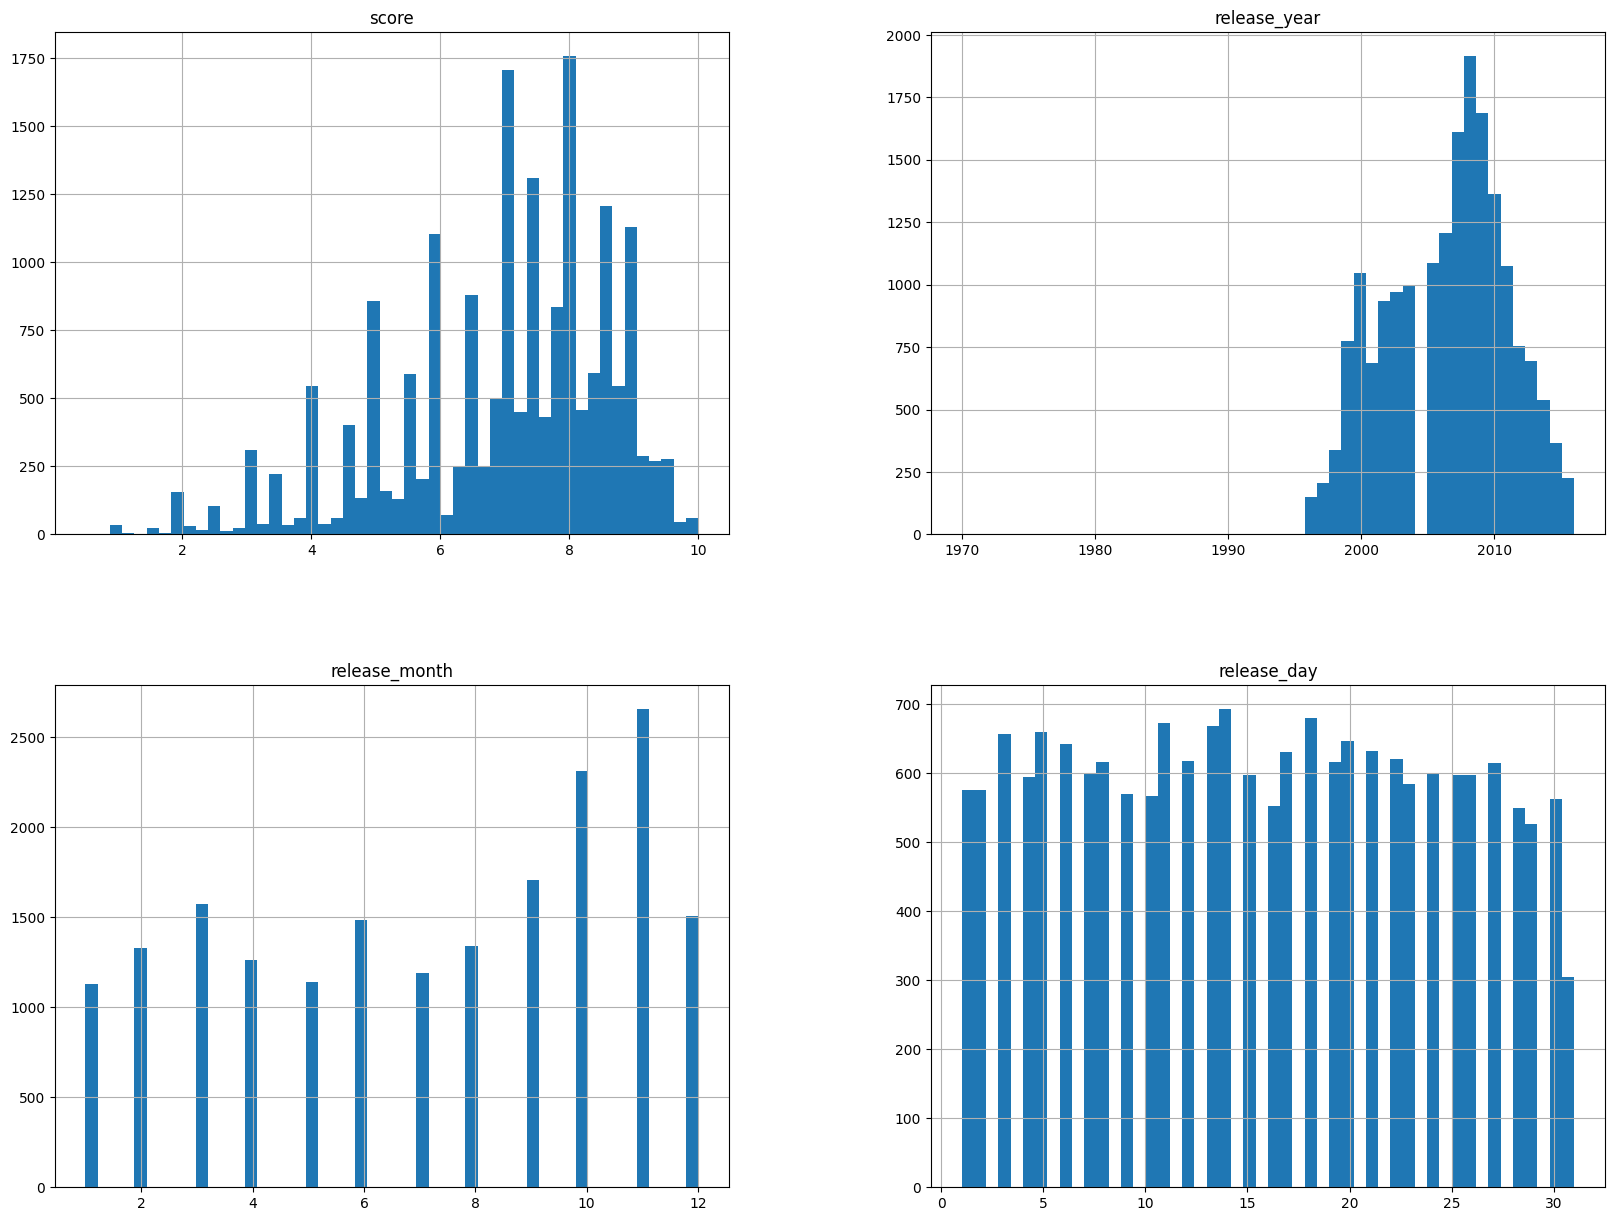

In [8]:
ign.hist(bins=50, figsize=(20,15))
plt.show()

É possível perceber que a maioria dos lançamentos se concentra entre 2006 e 2011.
Também é possível perceber que há dados faltantes para `release_year` de 2004.

O `score` é o target, ou seja, a variável que queremos prever. É possível perceber que o score varia de 0 a 10, com uma média de 6.95 e desvio padrão de 1.71.

In [9]:
category_columns = list(ign.describe(include=['O']).columns)
category_columns

['score_phrase', 'platform', 'genre', 'editors_choice']

In [10]:
ign['score_phrase'].value_counts()

Great          4773
Good           4741
Okay           2945
Mediocre       1959
Amazing        1804
Bad            1269
Awful           664
Painful         340
Unbearable       72
Masterpiece      55
Disaster          3
Name: score_phrase, dtype: int64

O `score_phrase` é uma descrição complementar ao `score`. 

Porém ela não contribui nenhuma informação para o modelo, pois é uma variável categórica que representa o `score` de forma redundante. Por exemplo, se o `score` é 8.5, então o `score_phrase` é "Great", e se o `score` é 7.0, então o `score_phrase` é "Good". 

Portanto, devemos descartar esta variável.

In [11]:
ign['platform'].value_counts()

PC                      3370
PlayStation 2           1686
Xbox 360                1631
Wii                     1366
PlayStation 3           1356
Nintendo DS             1045
PlayStation              952
Wireless                 910
iPhone                   842
Xbox                     821
PlayStation Portable     633
Game Boy Advance         623
GameCube                 509
Game Boy Color           356
Nintendo 64              302
Dreamcast                286
PlayStation 4            277
Nintendo DSi             254
Nintendo 3DS             225
Xbox One                 208
PlayStation Vita         155
Wii U                    114
iPad                      99
Lynx                      82
Macintosh                 81
Genesis                   58
NES                       49
TurboGrafx-16             40
Android                   39
Super NES                 33
NeoGeo Pocket Color       31
N-Gage                    30
Game Boy                  22
iPod                      17
Sega 32X      

A `platform` indica a plataforma em que o jogo foi lançado. É possível perceber que há 59 plataformas diferentes, sendo que a maioria dos jogos foi lançada para o PC, seguido pelo PlayStation 2, Xbox 360.

É interessante notar que no mundo dos video-games convenciona-se que os consoles (todas as plataformas que não são PC, Mobile ou Handheld) são divididos por gerações. Isso se encaixa no conceito da variável `release_year`, pois é possível perceber, por exemplo, que a maioria dos jogos lançados para o PlayStation 2 foram lançados entre 2000 e 2006, que é o período em que o console estava no auge (geração corrente), e recebia suporte das produtoras de jogos.

Para que essa análise seja mais clara, vamos criar uma nova variável chamada `generation`, que indica a geração do console em que o jogo foi lançado. Ainda neste mesmo tópico, vamos criar uma nova variável chamada `lifetime`, que é intermediária entre `release_year` e `generation`, e indica o tempo de vida do console em que o jogo foi lançado, ou seja, o tempo entre o lançamento do console e o lançamento do jogo.

Corroborado pela análise do retorno dos método `describe()` e `hist()` realizados na variável `release_year`, é possível perceber que há uma amostragem muito pequena de jogos lançados antes de 1996, o que pode prejudicar o modelo. Portanto, vamos remover todos os jogos lançados antes de 1996.

Tambem será necessário fazer um pré-processamento nesta variável, pois há plataformas que possuem poucos jogos, como `SteamOS`, `New Nintendo 3DS`, que podem acabar caindo somente no conjunto de treino ou teste. Portanto, retiraremos todas as plataformas que possuem menos de 100 jogos. Além disso, plataformas de dispositivos móveis como `iPhone`, `iPad`, `Android`, `Wireless` (multiplataforma para celulares) e `Windows Phone` serão colocadas na categoria `Mobile`, assim como combinaremos os consoles portáteis em uma categoria chamada `Handheld`. Por fim, transformaremos a coluna `platform`, substituindo o nome de cada console pelo nome da fabricante do console, como `Nintendo`, `Playstation`, `Xbox`, `PC`, `Handheld` ou `Mobile`.

In [12]:
ign['genre'].value_counts()

Action                      3797
Sports                      1916
Shooter                     1610
Racing                      1228
Adventure                   1175
                            ... 
Pinball, Compilation           1
Compilation, Compilation       1
Action, Editor                 1
Other, Action                  1
Shooter, Adventure             1
Name: genre, Length: 112, dtype: int64

A `genre` indica o gênero do jogo. Exitem 112 diferentes gêneros. Porém, deste valor temos que vários deles que são a união de dois ou mais gêneros. Para lidar com isso, vamos usar o método `str.split()` para separar os gêneros e criar uma lista de gêneros para cada jogo. Em seguida, vamos usar o método `explode()` para criar uma linha para cada gênero. Por fim, vamos remover os gêneros que possuem menos de 100 jogos, pois podem acabar caindo somente no conjunto de treino ou teste.

In [13]:
ign['editors_choice'].value_counts()

N    15108
Y     3517
Name: editors_choice, dtype: int64

A `editors_choice` indica se o jogo foi escolhido como o melhor do mês pelos editores da IGN. É possível pensar que possa haver uma correlação entre esta variável e o `score`, pois se o jogo foi escolhido como o melhor do mês, é provável que ele tenha um score alto. Portanto, pode ser interessante analisar a correlação entre estas duas variáveis.

### Pré-processamento

Devemos remover as colunas `score_phrase`, pois ela não contribui com nenhuma informação para o modelo, e retirar os jogos lançados antes de 1996, e também os jogos de plataformas que possuem menos de 100 jogos, pois podem acabar caindo somente no conjunto de treino ou teste.

In [14]:
ign.drop(['score_phrase'], axis=1, inplace=True)
ign

,platform,score,genre,editors_choice,release_year,release_month,release_day
0,PlayStation Vita,9.0,Platformer,Y,2012,9,12
1,PlayStation Vita,9.0,Platformer,Y,2012,9,12
2,iPad,8.5,Puzzle,N,2012,9,12
3,Xbox 360,8.5,Sports,N,2012,9,11
4,PlayStation 3,8.5,Sports,N,2012,9,11
...,...,...,...,...,...,...,...
18620,Wii U,7.6,RPG,N,2016,6,29
18621,PlayStation 4,9.0,"Action, Adventure",Y,2016,6,29
18622,PlayStation 4,5.8,RPG,N,2016,6,28
18623,Xbox One,10.0,Adventure,Y,2016,6,28


In [15]:
# dropamos os jogos antes de 1996, pois não temos dados suficientes para eles
ign = ign[ign['release_year'] >= 1996]

# dropamos todas as plataformas que não possuem pelo menos 100 jogos
ign = ign.groupby('platform').filter(lambda x: len(x) >= 100)

# pela baixíssima quantidade de jogos da Sega (que somente restou o DreamCast), decidimos ignorar essa plataforma
ign = ign[ign['platform'] != 'Dreamcast']

Em seguida, devemos realizar o pré-processamento da variável `platform`, criando as variáveis `generation` e `lifetime`, e agrupando as plataformas menos populares.

In [16]:
# declaramos as plataformas do tipo 'mobile' para serem agrupadas
mobile = ['iPhone', 'Wireless']
ign['platform'] = ign['platform'].apply(lambda x: 'Mobile' if x in mobile else x)

# criamos a coluna `lifetime`, variável que o tempo entre o lançamento do jogo e o lançamento da plataforma
ign['lifetime'] = ign['release_year'] - ign.groupby('platform')['release_year'].transform('min')

# se o jogo foi lançado para PC or Mobile, o tempo de vida é -1
ign.loc[ign['platform'] == 'PC', 'lifetime'] = -1
ign.loc[ign['platform'] == 'Mobile', 'lifetime'] = -1

In [17]:
# declaramos as plataformas do tipo 'handheld' para serem agrupadas
handhelds = ['Nintendo DS', 'PlayStation Portable', 'Game Boy Advance', 'Game Boy Color', 'Nintendo DSi', 'Nintendo 3DS', 'PlayStation Vita']
ign['platform'] = ign['platform'].apply(lambda x: 'Handheld' if x in handhelds else x)

In [18]:
# criamos a coluna de `generation`
gen_5 = ['PlayStation', 'Nintendo 64']
gen_6 = ['PlayStation 2', 'Xbox', 'GameCube']
gen_7 = ['Wii', 'PlayStation 3', 'Xbox 360']
gen_8 = ['PlayStation 4', 'Xbox One', 'Wii U']

# se a plataforma não estiver em nenhuma das gerações, ela é -1
ign['generation'] = ign['platform'].apply(lambda x: 0 if x in gen_5 else (1 if x in gen_6 else (2 if x in gen_7 else (3 if x in gen_8 else -1))))

ign['generation'].value_counts()

-1    8413
 2    4352
 1    3016
 0    1254
 3     599
Name: generation, dtype: int64

In [19]:
# declaramos as plataformas do tipo 'console' para serem agrupadas
nintendo = ['Wii U', 'Nintendo 64', 'GameCube', 'Wii']
ign['platform'] = ign['platform'].apply(lambda x: 'Nintendo' if x in nintendo else x)

xbox = ['Xbox 360', 'Xbox', 'Xbox One']
ign['platform'] = ign['platform'].apply(lambda x: 'Xbox' if x in xbox else x)

playstation = ['PlayStation 4', 'PlayStation 3', 'PlayStation 2', 'PlayStation']
ign['platform'] = ign['platform'].apply(lambda x: 'PlayStation' if x in playstation else x)

ign['platform'].value_counts()

PlayStation    4271
PC             3370
Handheld       3291
Xbox           2659
Nintendo       2291
Mobile         1752
Name: platform, dtype: int64

In [20]:
# remove all the nan values in genre
ign = ign[ign['genre'].notnull()]

In [21]:
# realizamos o split das variáveis que possuem múltiplos gêneros
ign.loc[:, 'genre'] = ign['genre'].str.split(',')
# em seguida, realizamos o explode dessas variáveis
ign = ign.explode('genre')
ign.reset_index(drop=True, inplace=True)

Por fim, devemos dropar a coluna `release_year`, pois ela não será mais necessária, assim como `release_day`, já que ela não contribui com nenhuma informação para o modelo. Por outro lado, o `release_month` pode ser interessante, pois pode haver uma correlação entre o mês de lançamento e o `score`.

In [22]:
ign.drop(['release_year', 'release_day'], axis=1, inplace=True)

Ao final do pré-processamento, devemos temos 20122 linhas e 6 features: `platform`, `genre`, `editors_choice`, `release_month`, `lifetime` e `generation`.

In [23]:
ign

,platform,score,genre,editors_choice,release_month,lifetime,generation
0,Handheld,9.0,Platformer,Y,9,0,-1
1,Handheld,9.0,Platformer,Y,9,0,-1
2,Xbox,8.5,Sports,N,9,8,2
3,PlayStation,8.5,Sports,N,9,6,2
4,Xbox,3.0,Fighting,N,9,8,2
...,...,...,...,...,...,...,...
20117,PlayStation,9.0,Action,Y,6,4,3
20118,PlayStation,9.0,Adventure,Y,6,4,3
20119,PlayStation,5.8,RPG,N,6,4,3
20120,Xbox,10.0,Adventure,Y,6,3,3


In [24]:
ign.describe()

,score,release_month,lifetime,generation
count,20122.000000,20122.000000,20122.000000,20122.000000
mean,6.967309,7.166335,2.105308,0.318358
std,1.698374,3.480920,2.663321,1.363773
min,0.500000,1.000000,-1.000000,-1.000000
25%,6.000000,4.000000,-1.000000,-1.000000
50%,7.300000,8.000000,2.000000,0.000000
75%,8.200000,10.000000,4.000000,2.000000
max,10.000000,12.000000,11.000000,3.000000


## Dividindo os dados em treino e teste

In [25]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(ign, test_size=0.2, random_state=RANDOM_SEED)

print('{} train + {} test'.format(len(train_set), len(test_set)))

16097 train + 4025 test


Realizamos a separação estratificada em relação a variável `generation`, pois buscamos manter a mesma proporção de jogos de cada geração nos conjuntos de treino e teste, o que impede que o modelo seja enviesado por conta de uma geração específica.

In [26]:
# Divide, de modo estratificado, o conjunto de dados.
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
for train_index, test_index in split.split(ign, ign['generation']):
    strat_train_set = ign.loc[train_index]
    strat_test_set = ign.loc[test_index]

In [27]:
strat_train_set['generation'].value_counts() / len(strat_train_set)

-1    0.467168
 2    0.249301
 1    0.181959
 0    0.066596
 3    0.034975
Name: generation, dtype: float64

In [28]:
strat_test_set['generation'].value_counts() / len(strat_test_set)

-1    0.467081
 2    0.249193
 1    0.182112
 0    0.066584
 3    0.035031
Name: generation, dtype: float64

In [29]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16097 entries, 333 to 1176
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   platform        16097 non-null  object 
 1   score           16097 non-null  float64
 2   genre           16097 non-null  object 
 3   editors_choice  16097 non-null  object 
 4   release_month   16097 non-null  int64  
 5   lifetime        16097 non-null  int64  
 6   generation      16097 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 1006.1+ KB


In [30]:
strat_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4025 entries, 10092 to 19540
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   platform        4025 non-null   object 
 1   score           4025 non-null   float64
 2   genre           4025 non-null   object 
 3   editors_choice  4025 non-null   object 
 4   release_month   4025 non-null   int64  
 5   lifetime        4025 non-null   int64  
 6   generation      4025 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 251.6+ KB


A partir de agora usaremos os conjuntos `strat_train_set` e `strat_test_set`. O conjunto `strat_train_set` será usado para várias explorações e para construir nosso modelo preditivo. O conjunto `strat_test_set` será usado só no final do projeto, para avaliar a performance final do nosso modelo.

## Explorando os dados de treino

Vamos verificar se há valores faltantes no dataset.

In [31]:
ign[ign.isnull().any(axis=1)].head()

,platform,score,genre,editors_choice,release_month,lifetime,generation


Como pudemos observar, não há valores faltantes no dataset.

### Correlação entre variáveis

In [32]:
correlation_matrix = ign.corr()
correlation_matrix["score"].sort_values(ascending=False)

score            1.000000
generation       0.023539
release_month    0.011517
lifetime        -0.053037
Name: score, dtype: float64

Interessante observar que as variáveis numéricas não apresentam um impacto muito grande no `score`, pois a correlação entre elas e o `score` é baixa. Porém ainda falta analisar a correlação entre as variáveis categóricas e o `score`.

### Separando variáveis dependentes e independentes

In [33]:
# Variáveis independentes: dataset original menos a coluna de valores dependentes.
ign = strat_train_set.drop('score', axis=1)

# Variável dependente, também chamada de label.
ign_labels = strat_train_set['score'].copy()

### Tratando variáveis categóricas

Devido ao fato de que as variáveis categóricas contidas neste dataset não são ordinais, devemos realizar o pré-processamento de *one-hot encoding*.

In [34]:
# Separar apenas as variáveis categóricas (neste caso temos apenas uma).
ign_cat = ign[['genre', 'platform', 'editors_choice']]

# Cria o codificador.
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(categories='auto')

# Aprende a codificação e já aplica a mesma ao dataset fornecido. Todo transformador no sklearn
# tem os métodos fit() para aprender a transformação, e transform() para aplicá-la.
# O método fit_transform() faz os dois atos em sequência.
ign_cat_1hot = encoder.fit_transform(ign_cat)

# Convertendo em matriz densa só para observar melhor:
print(ign_cat_1hot.toarray()[:5])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]]


In [35]:
encoder.categories_

[array([' Action', ' Adult', ' Adventure', ' Baseball', ' Battle', ' Card',
        ' Compilation', ' Editor', ' Episodic', ' Fighting',
        ' First-Person', ' Golf', ' Other', ' Party', ' Platformer',
        ' Productivity', ' Puzzle', ' RPG', ' Racing', ' Shooter',
        ' Simulation', ' Strategy', ' Trivia', ' Word Game', 'Action',
        'Adult', 'Adventure', 'Baseball', 'Battle', 'Board', 'Card',
        'Casino', 'Compilation', 'Educational', 'Fighting', 'Flight',
        'Hardware', 'Hunting', 'Music', 'Other', 'Party', 'Pinball',
        'Platformer', 'Productivity', 'Puzzle', 'RPG', 'Racing', 'Shooter',
        'Simulation', 'Sports', 'Strategy', 'Trivia', 'Virtual Pet',
        'Wrestling'], dtype=object),
 array(['Handheld', 'Mobile', 'Nintendo', 'PC', 'PlayStation', 'Xbox'],
       dtype=object),
 array(['N', 'Y'], dtype=object)]